In [16]:
#Conexió al Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd
TVDI = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/TVDI_model_clear.csv')

In [51]:
TVDI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9012 entries, 0 to 9011
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Data              9012 non-null   object 
 1   Hora              9012 non-null   object 
 2   Mes               9012 non-null   int64  
 3   Campanya          9012 non-null   int64  
 4   EAM               9012 non-null   object 
 5   id_pol            9012 non-null   int64  
 6   cat_cultiu        9012 non-null   object 
 7   T                 9012 non-null   float64
 8   Tmax              9012 non-null   float64
 9   Tmin              9012 non-null   float64
 10  H                 9012 non-null   int64  
 11  I                 9012 non-null   float64
 12  Evo               9012 non-null   float64
 13  v                 9012 non-null   float64
 14  Precipitacio_dia  9012 non-null   float64
 15  TVDI              9012 non-null   float64
 16  ETc               9012 non-null   float64


MODEL PINNS

In [52]:
import os, random
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score, mean_absolute_error

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

TVDI['Data'] = pd.to_datetime(TVDI['Data'])
TVDI = TVDI.set_index('Data')

# Definició de dia de l'any i creació varaible ciclica

TVDI['D']  = TVDI.index.dayofyear

TVDI['doy_sin']  = np.sin(2 * np.pi * TVDI['D'] / 365)
TVDI['doy_cos']  = np.cos(2 * np.pi * TVDI['D'] / 365)

# Eliminació nulls per seguretat
TVDI = TVDI.dropna()


# Varibales d'entrrada del model
features_num = [
    'T','Evo','I','v','VPD','ETc','H',
    'Precipitacio_dia','doy_sin', 'doy_cos', 'id_pol']

# Codificar EAM per entrar com a categorica
le_eam = LabelEncoder()
TVDI['EAM_enc'] = le_eam.fit_transform(TVDI['EAM'])

le_cat = LabelEncoder()
TVDI['cat_enc'] = le_cat.fit_transform(TVDI['cat_cultiu'])

In [53]:
# Separar entrades
X_num = TVDI[features_num].values
X_cat = TVDI['cat_enc'].values
X_mes = (TVDI['Mes'] - 11).values
X_eam = TVDI['EAM_enc'].values
y = TVDI['TVDI'].values.reshape(-1, 1)

In [55]:
# Entrenament/Test
X_num_train, X_num_test, \
X_cat_train, X_cat_test, \
X_mes_train, X_mes_test, \
X_eam_train, X_eam_test, \
y_train, y_test = train_test_split(
    X_num,
    X_cat,
    X_mes,
    X_eam,
    y,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

In [56]:
# Escalar dades numèriques i varaible objectiu
scaler_num = StandardScaler().fit(X_num_train)
X_num_train_scaled = scaler_num.transform(X_num_train)
X_num_test_scaled = scaler_num.transform(X_num_test)

scaler_y = MinMaxScaler().fit(y_train.reshape(-1, 1))
y_train_scaler = scaler_y.transform(y_train.reshape(-1, 1))
y_test_scaler = scaler_y.transform(y_test.reshape(-1, 1))

In [57]:
# Inputs
input_num = Input(shape=(X_num_train_scaled.shape[1],))
input_cat = Input(shape=(1,))
input_eam = Input(shape=(1,))
input_mes = Input(shape=(1,))

# Embedding per cat
embedding_cat = Embedding(input_dim=len(le_cat.classes_), output_dim=3)(input_cat)
embedding_cat = Flatten()(embedding_cat)

# Embedding per Mes
embedding_mes = Embedding(input_dim=5, output_dim=2)(input_mes)
embedding_mes = Flatten()(embedding_mes)

# Embedding per EAM
embedding_eam = Embedding(input_dim=len(le_eam.classes_), output_dim=2)(input_eam)
embedding_eam = Flatten()(embedding_eam)

In [84]:
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, Concatenate, Layer, LeakyReLU
from tensorflow.keras import regularizers

class SimplePINN_TVDI(Model):
    def __init__(self,n_cat, n_eam, n_mes,
                 # Pesos per a les restriccions
                 mono_vpd_weight=0.0,
                 mono_etc_weight=0.0,
                 mono_ETo_weight=0.0,
                 mono_T_weight=0.0,
                 mono_I_weight=0.0,
                 mono_H_weight=0.0,
                 # Referència índex varaible a x_num
                 idx_T = 0,
                 idx_ETo = 1,
                 idx_I = 2,
                 idx_VPD = 4,
                 idx_ETc = 5,
                 idx_H = 6,
                ):
        super().__init__()
        # Guaedar pesos
        self.mono_vpd_weight = mono_vpd_weight
        self.mono_etc_weight = mono_etc_weight
        self.mono_ETo_weight = mono_ETo_weight
        self.mono_T_weight = mono_T_weight
        self.mono_I_weight = mono_I_weight
        self.mono_H_weight = mono_H_weight

        # Guardar índexs de dades numeriques entrada model
        self.idx_T = idx_T
        self.idx_ETo = idx_ETo
        self.idx_I = idx_I
        self.idx_VPD = idx_VPD
        self.idx_ETc = idx_ETc
        self.idx_H = idx_H

        # Capes embendding (tipus categoria cultiu)

        self.embedding_cat = Embedding(input_dim=n_cat, output_dim=3)
        self.embedding_eam = Embedding(input_dim=n_eam, output_dim=3)
        self.embedding_mes = Embedding(input_dim=n_mes, output_dim=2)


        self.concat = Concatenate(name='merge_inputs')

        # Definició del model
        self.dense1    = Dense(256, kernel_regularizer=regularizers.l2(1e-4), name='dense_1')
        self.bn1       = BatchNormalization(name='batch_1')
        self.act1      = LeakyReLU(alpha=0.1, name='act_1')
        self.drop1     = Dropout(0.4, name='dropout_1')

        self.dense2    = Dense(128, kernel_regularizer=regularizers.l2(1e-4), name='dense_2')
        self.bn2       = BatchNormalization(name='batch_2')
        self.act2      = LeakyReLU(alpha=0.1, name='act_2')
        self.drop2     = Dropout(0.3, name='dropout_2')

        self.dense3    = Dense(64, kernel_regularizer=regularizers.l2(1e-4), name='dense_3')
        self.bn3       = BatchNormalization(name='batch_3')
        self.act3      = LeakyReLU(alpha=0.1, name='act_3')
        self.drop3     = Dropout(0.3, name='dropout_3')

        self.output_layer = Dense(1, activation='sigmoid', name='output_TVDI')


    # Crida de variables i model
    def call(self, inputs, training=False):
        x_num, x_cat, x_eam, x_mes = inputs

        e_cat = Flatten()(self.embedding_cat(x_cat))
        e_eam = Flatten()(self.embedding_eam(x_eam))
        e_mes = Flatten()(self.embedding_mes(x_mes))


        x = self.concat([x_num, e_cat, e_eam, e_mes])

        x = self.dense1(x)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.drop1(x, training=training)

        x = self.dense2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.drop2(x, training=training)

        x = self.dense3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)
        x = self.drop3(x, training=training)

        return self.output_layer(x)

    def train_step(self, data):
        (x_num, x_cat, x_eam, x_mes), (y_true_scale) = data

        x_num = tf.cast(x_num, tf.float32)
        x_cat = tf.cast(x_cat, tf.int32)
        x_eam = tf.cast(x_eam, tf.int32)
        x_mes = tf.cast(x_mes, tf.int32)

        y_true_scale = tf.cast(y_true_scale, tf.float32)


        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_num)
            y_pred_scale = self([x_num, x_cat, x_eam, x_mes], training=True)
            loss_data = self.compiled_loss(y_true_scale, y_pred_scale, regularization_losses=self.losses)

            raw_loss_mono_VPD = tf.constant(0.0, dtype=tf.float32)
            raw_loss_mono_ETc = tf.constant(0.0, dtype=tf.float32)
            raw_loss_mono_ETo = tf.constant(0.0, dtype=tf.float32)
            raw_loss_mono_T = tf.constant(0.0, dtype=tf.float32)
            raw_loss_mono_I = tf.constant(0.0, dtype=tf.float32)
            raw_loss_mono_H = tf.constant(0.0, dtype=tf.float32)


            calculate_grads_for_mono = (self.mono_vpd_weight > 0 or
                                        self.mono_etc_weight > 0 or
                                        self.mono_ETo_weight > 0 or
                                        self.mono_T_weight > 0 or
                                        self.mono_I_weight > 0 or
                                        self.mono_H_weight > 0)

            # Gradients per calcul de pèrdua i pèrdua amb tf.nn.relu
            if calculate_grads_for_mono:
                grad_all = tape.gradient(y_pred_scale, x_num)
                if grad_all is not None:
                    # TVDI augmenta amb VPD
                    if self.mono_vpd_weight > 0:
                        raw_loss_mono_VPD = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_VPD]))
                    # TVDI augmenta amb ETc potencial
                    if self.mono_etc_weight > 0:
                        raw_loss_mono_ETc = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_ETc]))
                    # TVDI augmenta amb ETo
                    if self.mono_ETo_weight > 0:
                        raw_loss_mono_ETo = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_ETo]))
                    # TVDI augmenta amb Temperatura
                    if self.mono_T_weight > 0:
                        raw_loss_mono_T = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_T]))
                    # TVDI augmenta amb Irradiació
                    if self.mono_I_weight > 0:
                        raw_loss_mono_I = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_I]))
                    # TVDI disminueix amb Humitat Relativa
                    if self.mono_H_weight > 0:
                        raw_loss_mono_H = tf.reduce_mean(tf.nn.relu(grad_all[:, self.idx_H]))
                else:
                    pass


            loss_total = (loss_data +
                           self.mono_vpd_weight * raw_loss_mono_VPD +
                           self.mono_etc_weight * raw_loss_mono_ETc +
                           self.mono_ETo_weight * raw_loss_mono_ETo +
                           self.mono_T_weight * raw_loss_mono_T +
                           self.mono_I_weight * raw_loss_mono_I +
                           self.mono_H_weight * raw_loss_mono_H)


        grads = tape.gradient(loss_total, self.trainable_variables)
        filtered_grads_and_vars = [(g, v) for g, v in zip(grads, self.trainable_variables) if g is not None]
        if len(filtered_grads_and_vars) != len(self.trainable_variables):
          pass
        if filtered_grads_and_vars:
             self.optimizer.apply_gradients(filtered_grads_and_vars)
        del tape

        self.compiled_metrics.update_state(y_true_scale, y_pred_scale)
        metrics_to_return = {m.name: m.result() for m in self.metrics}
        metrics_to_return["loss"] = loss_total
        metrics_to_return["data_loss"] = loss_data
        if self.mono_vpd_weight > 0: metrics_to_return["mono_vpd_loss"] = raw_loss_mono_VPD
        if self.mono_etc_weight > 0: metrics_to_return["mono_etc_loss"] = raw_loss_mono_ETc
        if self.mono_ETo_weight > 0: metrics_to_return["mono_eto_loss"] = raw_loss_mono_ETo
        if self.mono_T_weight > 0: metrics_to_return["mono_T_loss"] = raw_loss_mono_T
        if self.mono_I_weight > 0: metrics_to_return["mono_I_loss"] = raw_loss_mono_I
        if self.mono_H_weight > 0: metrics_to_return["mono_H_loss"] = raw_loss_mono_H

        return metrics_to_return

    def test_step(self, data):
        (x_num, x_cat, x_ema, x_mes), (y_true_scale) = data
        x_num = tf.cast(x_num, tf.float32)
        x_cat = tf.cast(x_cat, tf.int32)
        x_ema = tf.cast(x_ema, tf.int32)
        x_mes = tf.cast(x_mes, tf.int32)
        y_true_scale = tf.cast(y_true_scale, tf.float32)


        y_pred_scale = self([x_num, x_cat, x_ema, x_mes], training=False)
        loss_data = self.compiled_loss(y_true_scale, y_pred_scale, regularization_losses=self.losses)


        raw_loss_mono_VPD = tf.constant(0.0, dtype=tf.float32)
        raw_loss_mono_ETc = tf.constant(0.0, dtype=tf.float32)
        raw_loss_mono_ETo = tf.constant(0.0, dtype=tf.float32)
        raw_loss_mono_T = tf.constant(0.0, dtype=tf.float32)
        raw_loss_mono_I = tf.constant(0.0, dtype=tf.float32)
        raw_loss_mono_H = tf.constant(0.0, dtype=tf.float32)

        calculate_grads_for_mono = (self.mono_vpd_weight > 0 or
                                    self.mono_etc_weight > 0 or
                                    self.mono_ETo_weight > 0 or
                                    self.mono_T_weight > 0 or
                                    self.mono_I_weight > 0 or
                                    self.mono_H_weight > 0)

        if calculate_grads_for_mono:
            with tf.GradientTape() as mono_tape:
                mono_tape.watch(x_num)
                y_tmp_pred_for_grads = self([x_num, x_cat, x_ema, x_mes], training=False)

            grad_all = mono_tape.gradient(y_tmp_pred_for_grads, x_num)
            if grad_all is not None:
                if self.mono_vpd_weight > 0: raw_loss_mono_VPD = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_VPD]))
                if self.mono_etc_weight > 0: raw_loss_mono_ETc = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_ETc]))
                if self.mono_ETo_weight > 0: raw_loss_mono_ETo = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_ETo]))
                if self.mono_T_weight > 0: raw_loss_mono_T = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_T]))
                if self.mono_I_weight > 0: raw_loss_mono_I = tf.reduce_mean(tf.nn.relu(-grad_all[:, self.idx_I]))
                if self.mono_H_weight > 0: raw_loss_mono_H = tf.reduce_mean(tf.nn.relu(grad_all[:, self.idx_H]))
            else:
                pass

        loss_total = (loss_data +
                       self.mono_vpd_weight * raw_loss_mono_VPD +
                       self.mono_etc_weight * raw_loss_mono_ETc +
                       self.mono_ETo_weight * raw_loss_mono_ETo +
                       self.mono_T_weight * raw_loss_mono_T +
                       self.mono_I_weight * raw_loss_mono_I +
                       self.mono_H_weight * raw_loss_mono_H)

        self.compiled_metrics.update_state(y_true_scale, y_pred_scale)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"loss": loss_total, "data_loss": loss_data})

        if self.mono_vpd_weight > 0: results["mono_vpd_loss"] = raw_loss_mono_VPD
        if self.mono_etc_weight > 0: results["mono_etc_loss"] = raw_loss_mono_ETc
        if self.mono_ETo_weight > 0: results["mono_eto_loss"] = raw_loss_mono_ETo
        if self.mono_T_weight > 0: results["mono_T_loss"] = raw_loss_mono_T
        if self.mono_I_weight > 0: results["mono_I_loss"] = raw_loss_mono_I
        if self.mono_H_weight > 0: results["mono_H_loss"] = raw_loss_mono_H

        return results

In [90]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

idx_T_def = 0
idx_ETo_def = 1
idx_I_def = 2
idx_VPD_def = 4
idx_ETc_def = 5
idx_H_def = 6

# Cambinacions de pesos de cada gradaient.
model = SimplePINN_TVDI(
    n_cat=len(le_cat.classes_),
    n_eam=len(le_eam.classes_),
    n_mes=11,
    mono_vpd_weight=0.0,
    mono_etc_weight=0.0,
    mono_ETo_weight=0.0,
    mono_T_weight=0.0,
    mono_I_weight=0.0,
    mono_H_weight=0.0,

    idx_T = idx_T_def,
    idx_ETo = idx_ETo_def,
    idx_I = idx_I_def,
    idx_VPD = idx_VPD_def,
    idx_ETc = idx_ETc_def,
    idx_H = idx_H_def
    )

model.compile(
    optimizer=Adam(5e-4),
    loss='mse',
    metrics=['mae']
)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [91]:
# Entrenament
history = model.fit(
    x=[X_num_train_scaled, X_cat_train, X_eam_train, X_mes_train],
    y=(y_train_scaler),
    validation_data=([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test], (y_test_scaler)),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R² (Validación): 0.890
MAE (Validación): 0.074


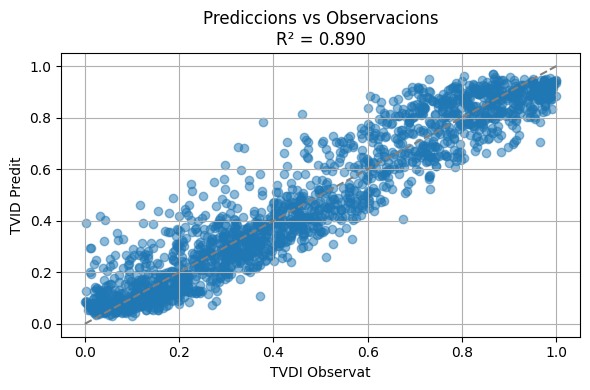

In [92]:
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Predicció
y_pred_scaled = model.predict([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test])
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_true = y_test.ravel()


r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"R² (Validación): {r2:.3f}")
print(f"MAE (Validación): {mae:.3f}")

# Scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('TVDI Observat')
plt.ylabel('TVID Predit')
plt.title(f'Prediccions vs Observacions\nR² = {r2:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [93]:
r, _ = pearsonr(y_true.ravel(), y_pred.ravel())
print(f"R: {r:.3f}")

R: 0.945


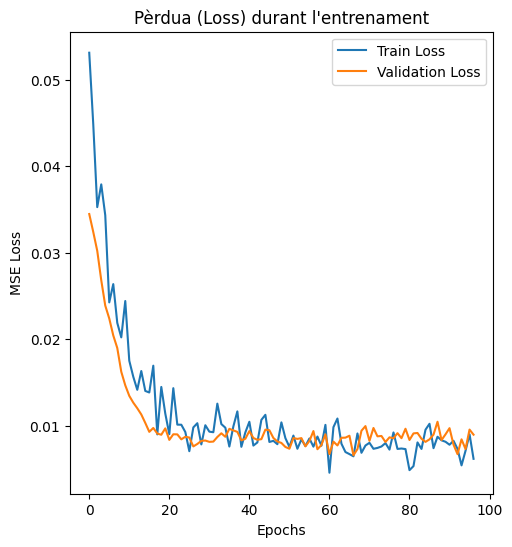

In [94]:
# Gràfics d'evolució de l'entrenament
plt.figure(figsize=(12, 6))

# Gràfic de la pèrdua (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pèrdua (Loss) durant l\'entrenament')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()


=== Trial 1/13: pesos = {'mono_vpd_weight': 0.0, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 → RMSE: 0.0953, R²: 0.8903, MAE: 0.0745

=== Trial 2/13: pesos = {'mono_vpd_weight': 1.0, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 → RMSE: 0.0960, R²: 0.8887, MAE: 0.0744

=== Trial 3/13: pesos = {'mono_vpd_weight': 1.1, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 → RMSE: 0.0961, R²: 0.8884, MAE: 0.0754

=== Trial 4/13: pesos = {'mono_vpd_weight': 1.2, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 → RMSE: 0.0953, R²: 0.8903, MAE: 0.0739

=== Trial 5/13: pesos = {'mono_vpd_weight': 1.3, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 → RMSE: 0.0962, R²: 0.8882, MAE: 0.0746

=== Trial 6/13: pesos = {'mono_vpd_weight': 1.4, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 → RMSE: 0.0963, R²: 0.8881, MAE: 0.0743

=== Trial 7/13: pesos = {'mono_vpd_weight': 1.5, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
 → RMSE: 0.0954, R²: 0.8902, MAE: 0.0737

=== Trial 8/13: pesos = {'mono_vpd_weight': 1.6, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 → RMSE: 0.0964, R²: 0.8878, MAE: 0.0737

=== Trial 9/13: pesos = {'mono_vpd_weight': 1.7, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 → RMSE: 0.0954, R²: 0.8900, MAE: 0.0744

=== Trial 10/13: pesos = {'mono_vpd_weight': 1.8, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 → RMSE: 0.0956, R²: 0.8897, MAE: 0.0745

=== Trial 11/13: pesos = {'mono_vpd_weight': 1.9, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 → RMSE: 0.0957, R²: 0.8895, MAE: 0.0744

=== Trial 12/13: pesos = {'mono_vpd_weight': 2.0, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 → RMSE: 0.0960, R²: 0.8887, MAE: 0.0743

=== Trial 13/13: pesos = {'mono_vpd_weight': 10, 'mono_etc_weight': 0.0, 'mono_ETo_weight': 0.0, 'mono_T_weight': 0.0, 'mono_I_weight': 0.0, 'mono_H_weight': 0.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
 → RMSE: 0.0961, R²: 0.8886, MAE: 0.0745

Taula de resultats per trial:
    n_cat  n_eam  n_mes  mono_vpd_weight  mono_etc_weight  mono_ETo_weight  \
0       6      2     11              0.0              0.0              0.0   
1       6      2     11              1.0              0.0              0.0   
2       6      2     11              1.1              0.0              0.0   
3       6      2     11              1.2              0.0              0.0   
4       6      2     11              1.3              0.0              0.0   
5       6      2     11              1.4              0.0              0.0   
6       6      2     11              1.5              0.0              0.0   
7       6      2     11              1.6              0.0              0.0   
8       6      2     11              1.7              0.0              0.0   
9       6      2     11              1.8              0.0              0.0   
10      6      2     11        

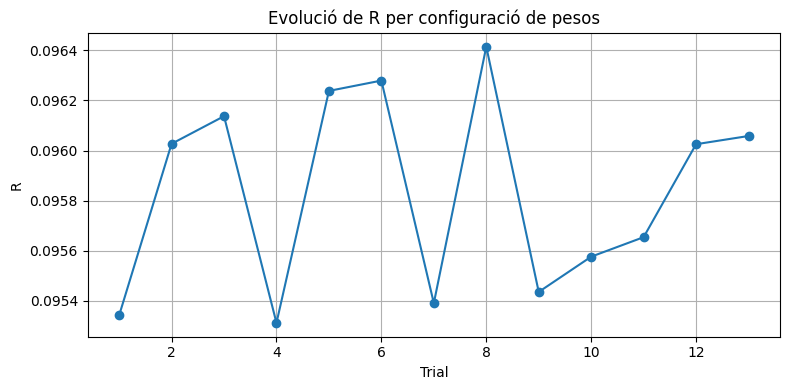

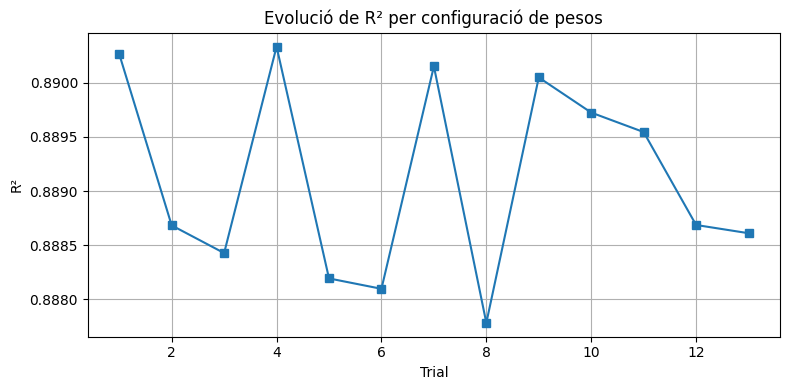

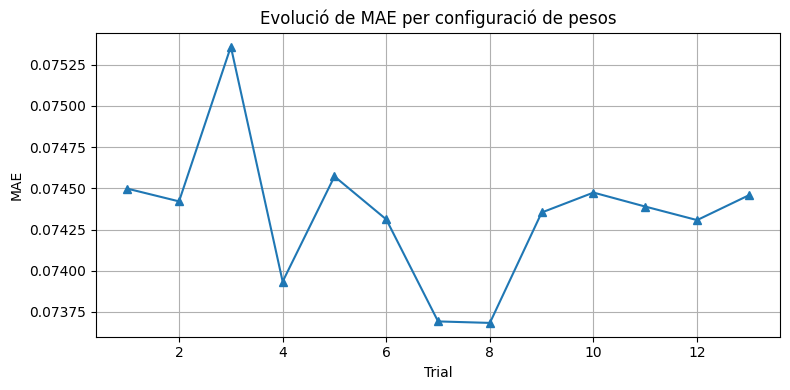

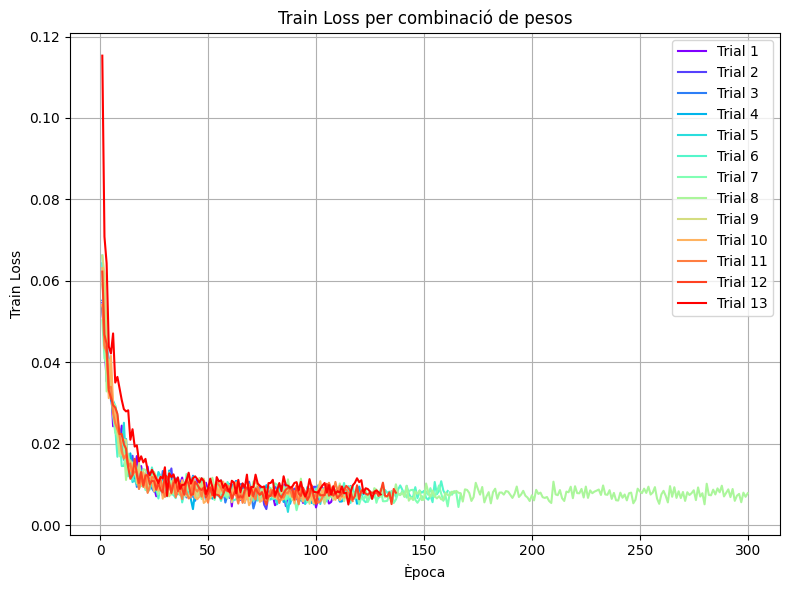

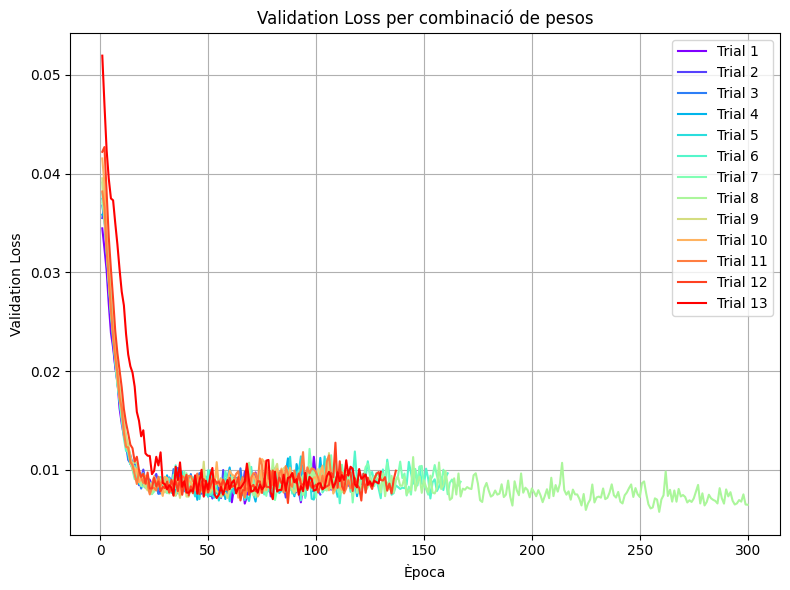

In [99]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib import cm


SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()


# Índexs fixes
idx_T_def   = 0
idx_ETo_def = 1
idx_I_def   = 2
idx_VPD_def = 4
idx_ETc_def = 5
idx_H_def   = 6

#Combinacions de pesos
var_weights = {
    'mono_vpd_weight': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'mono_etc_weight': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ],
    'mono_ETo_weight': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ],
    'mono_T_weight':   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ],
    'mono_I_weight':   [0.0, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 10 ],
    'mono_H_weight':   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 ],
}

num_trials = len(next(iter(var_weights.values())))

results = []
histories = {}

for i in range(num_trials):
    kwargs = {
        'n_cat': len(le_cat.classes_),
        'n_eam': len(le_eam.classes_),
        'n_mes': 11,
        'mono_vpd_weight': var_weights.get('mono_vpd_weight', [0]*num_trials)[i],
        'mono_etc_weight':  var_weights.get('mono_etc_weight',  [0]*num_trials)[i],
        'mono_ETo_weight':  var_weights.get('mono_ETo_weight',  [0]*num_trials)[i],
        'mono_T_weight':    var_weights.get('mono_T_weight',    [0]*num_trials)[i],
        'mono_I_weight':    var_weights.get('mono_I_weight',    [0]*num_trials)[i],
        'mono_H_weight':    var_weights.get('mono_H_weight',    [0]*num_trials)[i],
        'idx_T':   idx_T_def,
        'idx_ETo': idx_ETo_def,
        'idx_I':   idx_I_def,
        'idx_VPD': idx_VPD_def,
        'idx_ETc': idx_ETc_def,
        'idx_H':   idx_H_def,
    }

    print(f"\n=== Trial {i+1}/{num_trials}: pesos =",
          {k:kwargs[k] for k in var_weights.keys()})

    #Crear i compilar el model
    model = SimplePINN_TVDI(**kwargs)
    model.compile(
        optimizer=Adam(5e-4),
        loss='mse',
        metrics=['mae']
    )

    #Entrenament
    early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    history = model.fit(
        x=[X_num_train_scaled, X_cat_train, X_eam_train, X_mes_train],
        y=y_train_scaler,
        validation_data=([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test], y_test_scaler),
        epochs=300,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Avaluació sobre test
    y_pred = model.predict([X_num_test_scaled, X_cat_test, X_eam_test, X_mes_test]).flatten()
    y_pred   = scaler_y.inverse_transform(y_pred.reshape(-1,1)).flatten()
    y_true   = scaler_y.inverse_transform(y_test_scaler.reshape(-1,1)).flatten()

    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_val   = r2_score(y_true, y_pred)
    mae_val  = mean_absolute_error(y_true, y_pred)

    print(f" → RMSE: {rmse_val:.4f}, R²: {r2_val:.4f}, MAE: {mae_val:.4f}")

    # Guardar resultats
    res = { **kwargs, 'rmse':rmse_val, 'r2':r2_val, 'mae':mae_val }
    results.append(res)
    histories[i] = history.history


df_res = pd.DataFrame(results)
print("\nTaula de resultats per trial:")
print(df_res)

df_res['trial'] = range(1, len(df_res) + 1)

# Gràfic d’evolució de R
plt.figure(figsize=(8, 4))
plt.plot(df_res['trial'], df_res['rmse'], marker='o')
plt.xlabel("Trial")
plt.ylabel("R")
plt.title("Evolució de R per configuració de pesos")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gràfic d’evolució de R²
plt.figure(figsize=(8, 4))
plt.plot(df_res['trial'], df_res['r2'], marker='s')
plt.xlabel("Trial")
plt.ylabel("R²")
plt.title("Evolució de R² per configuració de pesos")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gràfic d’evolució de MAE
plt.figure(figsize=(8, 4))
plt.plot(df_res['trial'], df_res['mae'], marker='^')
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.title("Evolució de MAE per configuració de pesos")
plt.grid(True)
plt.tight_layout()
plt.show()

num_trials = len(histories)

colors = cm.rainbow(np.linspace(0, 1, num_trials))
labels = [f"Trial {i+1}" for i in range(num_trials)]

# Gràfica de Train Loss
plt.figure(figsize=(8, 6))
for i, color in enumerate(colors):
    h = histories[i]
    epochs = range(1, len(h['loss']) + 1)
    plt.plot(epochs, h['loss'],
             label=labels[i],
             color=color)
plt.xlabel('Època')
plt.ylabel('Train Loss')
plt.title('Train Loss per combinació de pesos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gràfica de Validation Loss
plt.figure(figsize=(8, 6))
for i, color in enumerate(colors):
    h = histories[i]
    epochs = range(1, len(h['val_loss']) + 1)
    plt.plot(epochs, h['val_loss'],
             label=labels[i],
             color=color)
plt.xlabel('Època')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per combinació de pesos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()